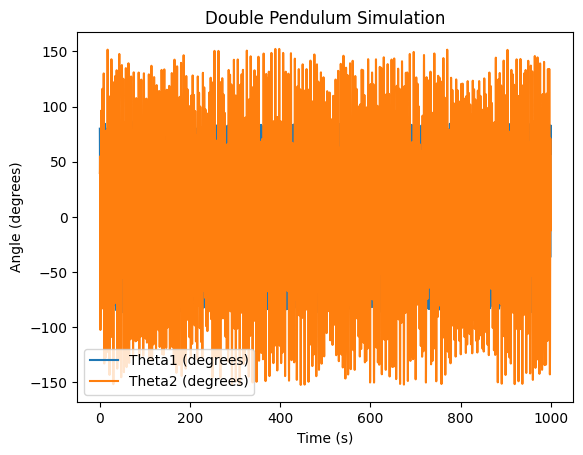

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi, radians, degrees

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Physical constants
g = 9.81  # Acceleration due to gravity (m/s^2)
L1 = 1  # Length of the first pendulum (m)
L2 = 1  # Length of the second pendulum (m)
m1 = 1.0  # Mass of the first pendulum (kg)
m2 = 1.0  # Mass of the second pendulum (kg)

# Derivative function for the double pendulum system
def f(r, t, g, L1, L2, m1, m2):
    theta1 = r[0]
    omega1 = r[1]
    theta2 = r[2]
    omega2 = r[3]

    # Equations of motion for the double pendulum
    ftheta1 = omega1
    fomega1 = (
        -g * (2 * m1 + m2) * sin(theta1)
        - m2 * g * sin(theta1 - 2 * theta2)
        - 2 * sin(theta1 - theta2) * m2 * (omega2 ** 2 * L2 + omega1 ** 2 * L1 * cos(theta1 - theta2))
    ) / (L1 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    ftheta2 = omega2
    fomega2 = (
        2 * sin(theta1 - theta2) * (omega1 ** 2 * L1 * (m1 + m2)
        + g * (m1 + m2) * cos(theta1)
        + omega2 ** 2 * L2 * m2 * cos(theta1 - theta2))
    ) / (L2 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    return np.array([ftheta1, fomega1, ftheta2, fomega2], float)

# Simulation parameters
a = 0.0  # Start time
b = 1000  # End time
N = 100000  # Number of time steps
h = (b - a) / N  # Time step size

# Time points
tpoints = np.arange(a, b, h)

# Pre-allocate arrays for theta1 and theta2
theta1_points = np.zeros_like(tpoints)
theta2_points = np.zeros_like(tpoints)

# Input initial conditions in degrees
theta1_deg = 80 # Initial angle for the first pendulum in degrees
omega1_deg = 0   # Initial angular velocity for the first pendulum in degrees per second
theta2_deg = 40 # Initial angle for the second pendulum in degrees
omega2_deg = 0   # Initial angular velocity for the second pendulum in degrees per second

# Convert initial conditions to radians for computation
q = np.array([radians(theta1_deg), radians(omega1_deg), radians(theta2_deg), radians(omega2_deg)], float)

# Runge-Kutta 4th order method loop
for i, t in enumerate(tpoints):
    # Store the angles in degrees for plotting
    theta1_points[i] = degrees(q[0])  # Convert radians to degrees
    theta2_points[i] = degrees(q[2])  # Convert radians to degrees

    # RK4 coefficients
    k1 = h * f(q, t, g, L1, L2, m1, m2)
    k2 = h * f(q + 0.5 * k1, t + 0.5 * h, g, L1, L2, m1, m2)
    k3 = h * f(q + 0.5 * k2, t + 0.5 * h, g, L1, L2, m1, m2)
    k4 = h * f(q + k3, t + h, g, L1, L2, m1, m2)

    # Update the state vector
    q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

# Plotting
plt.plot(tpoints, theta1_points, label='Theta1 (degrees)')
plt.plot(tpoints, theta2_points, label='Theta2 (degrees)')
plt.title("Double Pendulum Simulation")
plt.xlabel("Time (s)")
plt.ylabel("Angle (degrees)")
plt.legend()
plt.show()


In [3]:
# Combine Data
data = np.stack((theta1_points, theta2_points), axis=1)
np.save('pendulum_data.npy', data)

# Load data
data = np.load('pendulum_data.npy')
theta1_points = data[:, 0]  # Theta1 data
theta2_points = data[:, 1]  # Theta2 data

# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data)

#Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

#Function for feature mapping
def polynomial_feature_mapping(data, degree):
    poly = PolynomialFeatures(degree)
    return poly.fit_transform(data)

# Parameters
SEQ_LENGTH = 64
POLY_DEGREE = 2

# Create sequences
X, y = create_sequences(data_normalized, SEQ_LENGTH)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Apply polynomial feature mapping
X_train = polynomial_feature_mapping(X_train.reshape(-1, 2 * SEQ_LENGTH), POLY_DEGREE)
X_val = polynomial_feature_mapping(X_val.reshape(-1, 2 * SEQ_LENGTH), POLY_DEGREE)
X_test = polynomial_feature_mapping(X_test.reshape(-1, 2 * SEQ_LENGTH), POLY_DEGREE)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


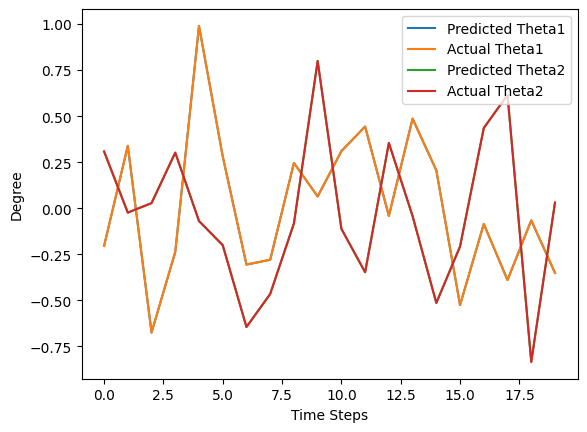

Test RMSE: 0.000086
Test R^2 Score: 0.9999999663215757


In [4]:
# Initialize the model
model = LinearRegression()

# Early stopping parameters
patience = 15
min_delta = 0.000001

# Lists to store losses
train_losses = []
val_losses = []

# Early stopping implementation
best_val_loss = float('inf')
counter = 0

model.fit(X_train, y_train)

# Training
train_pred = model.predict(X_train)
train_loss = mean_squared_error(y_train, train_pred)
train_losses.append(train_loss)

# Validation
val_pred = model.predict(X_val)
val_loss = mean_squared_error(y_val, val_pred)
val_losses.append(val_loss)

# Early stopping
if val_loss < best_val_loss - min_delta:
    best_val_loss = val_loss
    counter = 0
else:
    counter += 1
    if counter >= patience:
        print("Early stopping")


# Evaluation on the test set
test_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, test_pred))
r2 = r2_score(y_test, test_pred)

plt.plot(test_pred[0:20, 0], label='Predicted Theta1')
plt.plot(y_test[0:20, 0], label='Actual Theta1')
plt.plot(test_pred[0:20, 1], label='Predicted Theta2')
plt.plot(y_test[0:20, 1], label='Actual Theta2')
plt.xlabel('Time Steps')
plt.ylabel('Degree')
plt.legend()
plt.show()

print(f'Test RMSE: {rmse:.6f}')
print(f'Test R^2 Score: {r2}')